In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)
import shutil
shutil.copytree(path, 'data')

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


'data'

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import os
import random
from google.colab import files

In [3]:
train_dir = 'data/seg_train/seg_train'
test_dir = 'data/seg_test/seg_test'

# Data generators with augmentation for train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # For evaluation
)

class_labels = list(train_generator.class_indices.keys())
print(f"Classes: {class_labels}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [35]:

from keras.models import Model
trainable_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers initially
trainable_model.trainable = False

output_layer = trainable_model.layers[-1]

x = Flatten()(output_layer.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs=trainable_model.input, outputs=x)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-1329070217.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  trainable_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 18,775,366 (71.62 MB)

 Trainable params: 16,517,382 (63.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

351/351 ━━━━━━━━━━━━━━━━━━━━ 111s 289ms/step - accuracy: 0.6535 - loss: 3.3280 - val_accuracy: 0.8231 - val_loss: 0.4900 - learning_rate: 0.0010


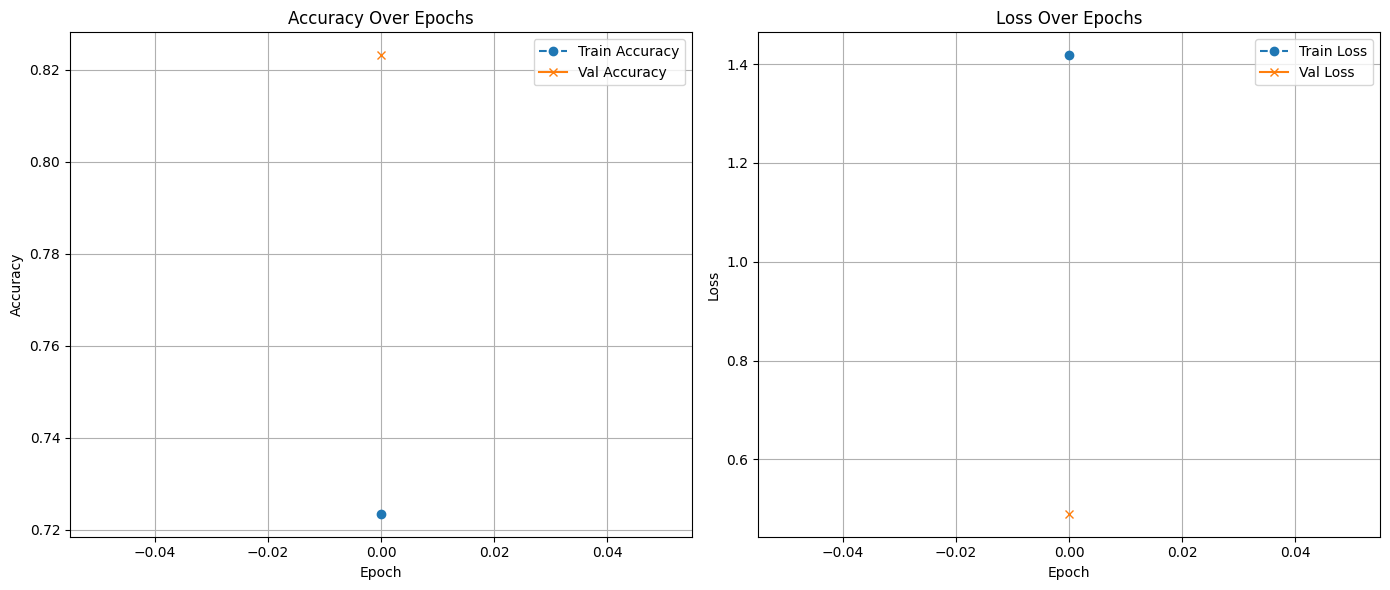

In [36]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train with more epochs, using callbacks
history = model.fit(
    train_generator,
    epochs=1,  # Increased for better training; early stopping will halt if needed
    validation_data=val_generator,
    callbacks=callbacks
)

# Enhanced plotting: Include learning rate if available, and use smoother lines
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='-', marker='x')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='-', marker='x')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation Results

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.8467 - loss: 0.4418
Test Loss: 0.3998
Test Accuracy: 84.70%
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step

Classification Report:


,precision,recall,f1-score,support
buildings,0.8402,0.8421,0.8411,437.000
forest,0.9811,0.9831,0.9821,474.000
glacier,0.8992,0.6456,0.7516,553.000
mountain,0.7068,0.8724,0.7809,525.000
sea,0.8619,0.9176,0.8889,510.000
street,0.8497,0.8463,0.8480,501.000
accuracy,0.8470,0.8470,0.8470,0.847
macro avg,0.8565,0.8512,0.8488,3000.000
weighted avg,0.8553,0.8470,0.8456,3000.000


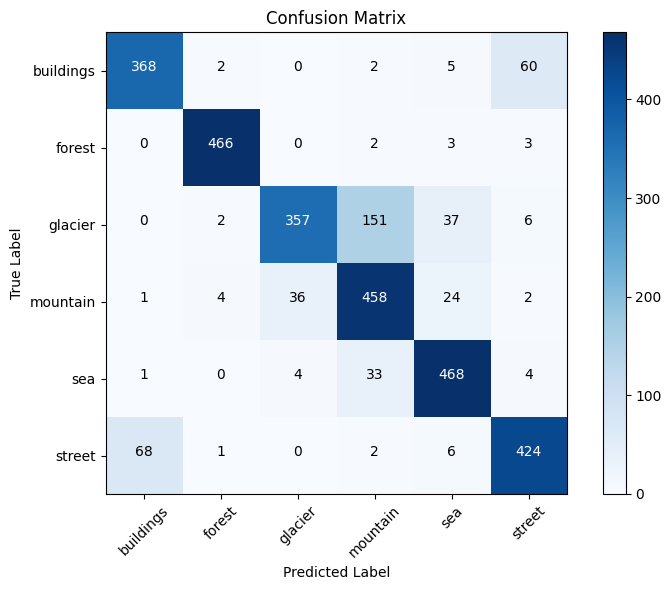


Confusion Matrix Table:


,buildings,forest,glacier,mountain,sea,street
buildings,368,2,0,2,5,60
forest,0,466,0,2,3,3
glacier,0,2,357,151,37,6
mountain,1,4,36,458,24,2
sea,1,0,4,33,468,4
street,68,1,0,2,6,424


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate classification report as a dictionary
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(report_dict).transpose().round(4)

# Display the metrics table (precision, recall, f1-score, support)
print("\nClassification Report:")
display(metrics_df)  # Use display() in Jupyter for nice HTML table output

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Optionally, display confusion matrix as a table
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
print("\nConfusion Matrix Table:")
display(cm_df)

In [7]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    return class_labels[class_idx]

# Upload image
uploaded = files.upload()
for fn in uploaded.keys():
    print(f"Predicted class for {fn}: {predict_image(fn)}")

# Or demo with a random test image
test_images = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith('.jpg'):
            test_images.append(os.path.join(root, file))

random_image = random.choice(test_images)
print(f"Random test image: {random_image}")
print(f"Predicted: {predict_image(random_image)}")
true_label = os.path.basename(os.path.dirname(random_image))
print(f"True Label: {true_label}")

KeyboardInterrupt: 

In [37]:
model.save('intel_scene_classifier.h5')